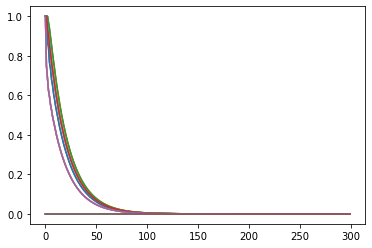

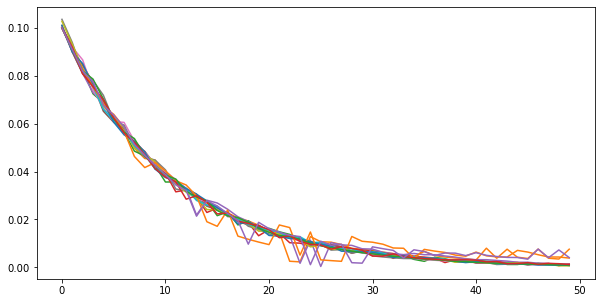

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from aima.mdp4e import MDP, policy_evaluation


class PassiveDUEAgent:
    """
    Passive (non-learning) agent that uses direct utility estimation
    on a given MDP and policy.

    import sys
    from mdp import sequential_decision_environment
    north = (0, 1)
    south = (0,-1)
    west = (-1, 0)
    east = (1, 0)
    policy = {(0, 2): east, (1, 2): east, (2, 2): east, (3, 2): None, (0, 1): north, (2, 1): north,
              (3, 1): None, (0, 0): north, (1, 0): west, (2, 0): west, (3, 0): west,}
    agent = PassiveDUEAgent(policy, sequential_decision_environment)
    for i in range(200):
        run_single_trial(agent,sequential_decision_environment)
        agent.estimate_U()
    agent.U[(0, 0)] > 0.2
    True
    """

    def __init__(self, pi, mdp):
        self.pi = pi
        self.mdp = mdp
        self.U = {}
        self.s = None
        self.a = None
        self.s_history = []
        self.r_history = []
        self.init = mdp.init

    def __call__(self, percept):
        s1, r1 = percept
        self.s_history.append(s1)
        self.r_history.append(r1)
        ##
        ##
        if s1 in self.mdp.terminals:
            self.s = self.a = None
        else:
            self.s, self.a = s1, self.pi[s1]
        return self.a

    def estimate_U(self):
        # this function can be called only if the MDP has reached a terminal state
        # it will also reset the mdp history
        assert self.a is None, 'MDP is not in terminal state'
        assert len(self.s_history) == len(self.r_history)
        # calculating the utilities based on the current iteration
        U2 = {s: [] for s in set(self.s_history)}
        for i in range(len(self.s_history)):
            s = self.s_history[i]
            U2[s] += [sum(self.r_history[i:])]
        U2 = {k: sum(v) / max(len(v), 1) for k, v in U2.items()}
        # resetting history
        self.s_history, self.r_history = [], []
        # setting the new utilities to the average of the previous
        # iteration and this one
        for k in U2.keys():
            if k in self.U.keys():
                self.U[k] = (self.U[k] + U2[k]) / 2
            else:
                self.U[k] = U2[k]
        return self.U

    def update_state(self, percept):
        """To be overridden in most cases. The default case
        assumes the percept to be of type (state, reward)"""
        return percept

    def direct_utility(self,state, trans, utility, reward, gamma):
        """
        function: direct_utility
        params: vevtor ints state, vevtor ints transition, vector ints utility, float reward, float gamma
        does: calculates the bellman equation for the utility of a state
        returns: the utility of a state float
        """
        actions = [0.0, 0.0, 0.0, 0.0]
        for action in range(0, 4):
            actions[action] = np.sum(np.multiply(utility, np.dot(state, trans[:,:,action])))
        out = reward + gamma * np.max(actions)
        return out

class PassiveADPAgent:
    """
    Passive (non-learning) agent that uses adaptive dynamic programming
    on a given MDP and policy.

    import sys
    from mdp import sequential_decision_environment
    north = (0, 1)
    south = (0,-1)
    west = (-1, 0)
    east = (1, 0)
    policy = {(0, 2): east, (1, 2): east, (2, 2): east, (3, 2): None, (0, 1): north, (2, 1): north,
              (3, 1): None, (0, 0): north, (1, 0): west, (2, 0): west, (3, 0): west,}
    agent = PassiveADPAgent(policy, sequential_decision_environment)
    for i in range(100):
        run_single_trial(agent,sequential_decision_environment)

    agent.U[(0, 0)] > 0.2
    True
    agent.U[(0, 1)] > 0.2
    True
    """

    class ModelMDP(MDP):
        """Class for implementing modified Version of input MDP with
        an editable transition model P and a custom function T."""

        def __init__(self, init, actlist, terminals, gamma, states):
            super().__init__(init, actlist, terminals, states=states, gamma=gamma)
            nested_dict = lambda: defaultdict(nested_dict)
            # StackOverflow:whats-the-best-way-to-initialize-a-dict-of-dicts-in-python
            self.P = nested_dict()

        def T(self, s, a):
            """Return a list of tuples with probabilities for states
            based on the learnt model P."""
            return [(prob, res) for (res, prob) in self.P[(s, a)].items()]

    def __init__(self, pi, mdp):
        self.pi = pi
        self.mdp = PassiveADPAgent.ModelMDP(mdp.init, mdp.actlist,
                                            mdp.terminals, mdp.gamma, mdp.states)
        self.U = {}
        self.Nsa = defaultdict(int)
        self.Ns1_sa = defaultdict(int)
        self.s = None
        self.a = None
        self.visited = set()  # keeping track of visited states

    def __call__(self, percept):
        s1, r1 = percept
        mdp = self.mdp
        R, P, terminals, pi = mdp.reward, mdp.P, mdp.terminals, self.pi
        s, a, Nsa, Ns1_sa, U = self.s, self.a, self.Nsa, self.Ns1_sa, self.U

        if s1 not in self.visited:  # Reward is only known for visited state.
            U[s1] = R[s1] = r1
            self.visited.add(s1)
        if s is not None:
            Nsa[(s, a)] += 1
            Ns1_sa[(s1, s, a)] += 1
            # for each t such that Ns鈥瞸sa [t, s, a] is nonzero
            for t in [res for (res, state, act), freq in Ns1_sa.items()
                      if (state, act) == (s, a) and freq != 0]:
                P[(s, a)][t] = Ns1_sa[(t, s, a)] / Nsa[(s, a)]

        self.U = policy_evaluation(pi, U, mdp)
        ##
        ##
        self.Nsa, self.Ns1_sa = Nsa, Ns1_sa
        if s1 in terminals:
            self.s = self.a = None
        else:
            self.s, self.a = s1, self.pi[s1]
        return self.a

    def update_state(self, percept):
        """To be overridden in most cases. The default case
        assumes the percept to be of type (state, reward)."""
        return percept

    def adp_rewards(self):
        def reward_function(pos, action):
            if pos in goal:
                return pos, 0
            reward = r
            end_pos = np.array(pos) + np.array(action)
            if -1 in end_pos or 4 in end_pos:
                end_pos = pos
            return end_pos, reward
        gamma = 1
        r = -1
        grid_constraint = 4
        goal = [[0, 0], [grid_constraint - 1, grid_constraint - 1]]
        actions = [[1, 0], [0, 1], [0, -1], [-1, 0]]
        iters = 300
        grid = np.zeros((grid_constraint, grid_constraint), dtype=float)
        state = [[state_1, state_2] for state_1 in range(grid_constraint) for state_2 in range(grid_constraint)]

        results = []
        # loop over total number of iterations set to 400, this can be changed untul the algorithm converges.
        for item in range(iters):
            copy_grid = np.copy(grid)
            states = []
            for s in state:
                weightedRewards = 0
                for action in actions:
                    end_pos, reward = reward_function(s, action)
                    weightedRewards += (1 / len(actions)) * (reward + (gamma * grid[end_pos[0], end_pos[1]]))
                states.append(np.abs(copy_grid[s[0], s[1]] - weightedRewards))
                copy_grid[s[0], s[1]] = weightedRewards
            results.append(states)
            grid = copy_grid
            #if item in [0, 50, 100, 150, 200, 250, iters - 1]:
                #print("Iteration:", item)
                #print(grid)

        plt.figure()
        plt.plot(results)
        plt.show()



class PassiveTDAgent:
    """
    The abstract class for a Passive (non-learning) agent that uses
    temporal differences to learn utility estimates. Override update_state
    method to convert percept to state and reward. The mdp being provided
    should be an instance of a subclass of the MDP Class.

    import sys
    from mdp import sequential_decision_environment
    north = (0, 1)
    south = (0,-1)
    west = (-1, 0)
    east = (1, 0)
    policy = {(0, 2): east, (1, 2): east, (2, 2): east, (3, 2): None, (0, 1): north, (2, 1): north,
              (3, 1): None, (0, 0): north, (1, 0): west, (2, 0): west, (3, 0): west,}
    agent = PassiveTDAgent(policy, sequential_decision_environment, alpha=lambda n: 60./(59+n))
    for i in range(200):
        run_single_trial(agent,sequential_decision_environment)

    agent.U[(0, 0)] > 0.2
    True
    agent.U[(0, 1)] > 0.2
    True
    """

    def __init__(self, pi, mdp, alpha=None):

        self.pi = pi
        self.U = {s: 0. for s in mdp.states}
        self.Ns = {s: 0 for s in mdp.states}
        self.s = None
        self.a = None
        self.r = None
        self.gamma = mdp.gamma
        self.terminals = mdp.terminals

        if alpha:
            self.alpha = alpha
        else:
            self.alpha = lambda n: 1 / (1 + n)  # udacity video

    def __call__(self, percept):
        s1, r1 = self.update_state(percept)
        pi, U, Ns, s, r = self.pi, self.U, self.Ns, self.s, self.r
        alpha, gamma, terminals = self.alpha, self.gamma, self.terminals
        if not Ns[s1]:
            U[s1] = r1
        if s is not None:
            Ns[s] += 1
            U[s] += alpha(Ns[s]) * (r + gamma * U[s1] - U[s])
        if s1 in terminals:
            self.s = self.a = self.r = None
        else:
            self.s, self.a, self.r = s1, pi[s1], r1
        return self.a

    def update_state(self, percept):
        return percept

    def td_rewards(self):
        gamma = 0.1
        r = -1
        grid = 4
        alpha = 0.1
        goal = [[0, 0], [grid - 1, grid - 1]]
        actions = [[1, 0], [0, 1], [0, -1], [-1, 0]]
        iters = 10000
        env = np.zeros((grid, grid))
        states = [[state_1, state_2] for state_1 in range(grid) for state_2 in range(grid)]
        deltas = {(i, j): list() for i in range(grid) for j in range(grid)}

        def init_state():
            """
            function: init_states
            params: none
            returns: ints init state
            """
            init_state = random.choice(states[1:-1])
            return init_state

        def get_next_action():
            """
            function: get_next_action
            params: none
            returns: makes a random choice of direction for the agent
            """
            return random.choice(actions)

        def reward_function_two(pos, action):
            """
            function: reward_function
            params: pos ints the initial position, action ints
            returns: the next position ints, and reward float
            """
            if list(pos) in goal:
                return 0, None
            end_state = np.array(pos) + np.array(action)

            if -1 in list(end_state) or grid in list(end_state):
                end_state = pos
            return r, list(end_state)

        for i in range(iters):
            state = init_state()
            while True:
                action = get_next_action()
                rew, end_state = reward_function_two(state, action)

                if end_state is None:
                    break
                # value function

                prev_states = env[state[0], state[1]]
                env[state[0], state[1]] += alpha * (
                        rew + gamma * env[end_state[0], end_state[1]] - env[state[0], state[1]])
                deltas[state[0], state[1]].append(float(np.abs(prev_states - env[state[0], state[1]])))
                state = end_state
        plt.figure(figsize=(10, 5))
        all_series = [list(x)[:50] for x in deltas.values()]
        for series in all_series:
            plt.plot(series)
        plt.show()

def run_single_trial(agent_program, mdp):
    """Execute trial for given agent_program
    and mdp. mdp should be an instance of subclass
    of mdp.MDP """

    def take_single_action(mdp, s, a):
        """
        Select outcome of taking action a
        in state s. Weighted Sampling.
        """
        x = random.uniform(0, 1)
        cumulative_probability = 0.0
        for probability_state in mdp.T(s, a):
            probability, state = probability_state
            cumulative_probability += probability
            if x < cumulative_probability:
                break
        return state

    current_state = mdp.init
    while True:
        current_reward = mdp.R(current_state)
        percept = (current_state, current_reward)
        next_action = agent_program(percept)
        if next_action is None:
            break
        current_state = take_single_action(mdp, current_state, next_action)

# ______________________________________________________________________________


""" 
A 4x3 grid environment that presents the agent with a sequential decision problem.
"""
import sys
from aima.mdp import sequential_decision_environment

north = (0, 1)
south = (0, -1)
west = (-1, 0)
east = (1, 0)
policy = {(0, 2): east, (1, 2): east, (2, 2): east, (3, 2): None, (0, 1): north, (2, 1): north,
          (3, 1): None, (0, 0): north, (1, 0): west, (2, 0): west, (3, 0): west, }
agentADP = PassiveADPAgent(policy, sequential_decision_environment)
agentTD = PassiveTDAgent(policy, sequential_decision_environment)
agentD = PassiveDUEAgent(policy, sequential_decision_environment)
agentADP.adp_rewards()
agentTD.td_rewards()
for i in range(200):
    run_single_trial(agentD, sequential_decision_environment)
    agentD.estimate_U()